# Reinforcement Learning Path-Finder

Todos:
* Improve training data distribution to provide more examples of difficult back-tracking scenarios
* Do we need more state info - multiple visits, previous states?
* Alternatively, can it learn 'left-hand' maze algorithm from current state info, or what more would be required?
* Port to alternative Solver class in open-spacial solution
* Run hyper-parameter optimisation

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Setup Scenario

In [0]:
def get_room(rank):
  return np.zeros((rank, rank), dtype=int)

def get_random_source(room):
  return random.choice(range(room.shape[0]))

def apply_occupancy(room, ids):
  [room.itemset(i, 2) for i in ids]

def apply_visit(room, ids):
  [room.itemset(i, 1) for i in ids]

def apply_random_occupancy(room, source, p):
  open_desks = list(range(room.size))
  open_desks.remove(source)
  ids = random.sample(open_desks, int(round(p * len(open_desks))))
  apply_occupancy(room, ids)

def generate_random_scenario(rank, p):
  room = get_room(rank)
  source = get_source(room)
  apply_random_occupancy(room, source, p)
  return room, source

def draw_room(room, visits=None):
  if visits is None:
    visits = np.zeros((room.shape[0], room.shape[1]))
  dr = room + visits
  #if path: dr.apply_visit(path)
  plt.imshow(dr, vmin=0, vmax=2, origin='lower', cmap='plasma')
  plt.show()

# Utility

In [0]:
def i2v(room, i):
  rank = room.shape[0]
  return (i // rank, i % rank)

def v2i(room, v):
  rank = room.shape[0]
  return v[0] * rank + v[1]

def is_front_row(room, i):
  rank = room.shape[0]
  return i // rank == rank - 1

def is_back_row(room, i):
  rank = room.shape[0]
  return i // rank == 0

def is_left_col(room, i):
  rank = room.shape[0]
  return i % rank == 0

def is_right_col(room, i):
  rank = room.shape[0]
  return i % rank == rank - 1

def row_fore(room, i):
  rank = room.shape[0]
  return i + rank

def row_back(room, i):
  rank = room.shape[0]
  return i - rank

def col_left(room, i):
  return i - 1

def col_right(room, i):
  rank = room.shape[0]
  return i + 1

def inbounds(room, v):
  return v[0] >= 0 and v[0] < room.shape[0] and v[1] >= 0 and v[1] < room.shape[1] 

# Environment, Actions and Agent

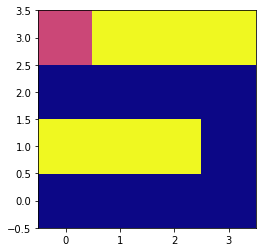

In [4]:
room = get_room(4)
visits = get_room(4)
apply_occupancy(room, [4, 5, 6])
apply_occupancy(room, [13, 14, 15])
source = 0
apply_visit(visits, [12])

draw_room(room, visits)

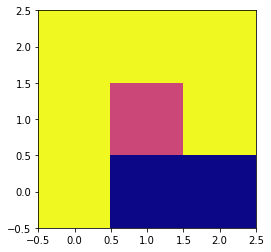

In [5]:
def get_extent(margin):
  return 2 * margin + 1

def get_locality(room, visits, pos, margin):
  o_r = i2v(room, pos)[0] - margin
  o_c = i2v(room, pos)[1] - margin
  extent = get_extent(margin)
  locality = np.zeros((extent, extent), dtype=int)
  for i in range(extent):
    r = o_r + i
    for j in range(extent):
      c = o_c + j
      if inbounds(room, (r, c)):
        locality[i][j] = room[r][c] + visits[r][c]
      else:
        locality[i][j] = 2
  return locality

loc = get_locality(room, visits, 12, 1)

draw_room(loc)

In [6]:
subs_move_ids = [7, 5, 1, 3, 4]

def get_region_state_id(region):
  #id_list = region.flatten()
  id_list = [region.item(i) for i in subs_move_ids]
  rsi = sum([3 ** (len(id_list) - 1 - i) * r for i, r in enumerate(id_list)])
  return int(rsi)

print(get_region_state_id(room))
print(get_region_state_id(loc))

56
223


In [7]:
num_states = (3 ** len(subs_move_ids)) * 2

def get_state_id(room, region, pos):
  region_state_id = get_region_state_id(region)
  return is_front_row(room, pos) + 2 * region_state_id

def get_goal_from_state(room, state):
  return state % 2

def get_region_from_state(room, state):
  return state // 2

print(get_state_id(room, loc, 0))

446


In [0]:
# actions - cardinal directions clockwise from 12 as per problem statement
actions = range(4)

# todo - this could use locality
def move_options(room, pos):
  blocked = np.zeros(4)
  blocked[0] = is_front_row(room, pos) or room.item(row_fore(room, pos)) == 2
  blocked[1] = is_right_col(room, pos) or room.item(col_right(room, pos)) == 2
  blocked[2] = is_back_row(room, pos) or room.item(row_back(room, pos)) == 2
  blocked[3] = is_left_col(room, pos) or room.item(col_left(room, pos)) == 2
  return np.logical_not(blocked)

move_fn = [row_fore, col_right, row_back, col_left]

# decided to not move anywhere if you try to move through block
# there are alternative ways to do this (eg, more semantic actions, fail)
def next_pos_state(room, visits, margin, pos, state, action):
  npos = move_fn[action](room, pos) if move_options(room, pos)[action] else pos
  apply_visit(visits, [npos])
  nloc = get_locality(room, visits, npos, margin)
  return npos, get_state_id(room, nloc, npos)

def is_goal(room, state):
  return get_goal_from_state(room, state)

def reward(room, state, action=None, next_state=None):
  r = 0
  if is_goal(room, state):
    r = 1
  elif next_state != state:
    r = 0.01 
  return r

# Q-Learning

486


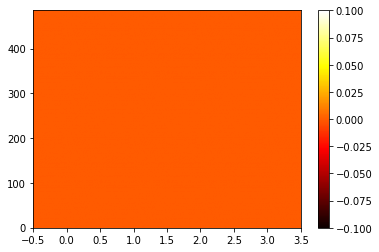

In [9]:
margin = 1
region_size = get_extent(margin) ** 2

room_rank = 6
occ_prop = 0.2

q_table = np.zeros((num_states, len(actions)))

print(num_states)
plt.imshow(q_table, origin='lower', aspect='auto', cmap='hot')
plt.colorbar()
plt.show()

In [0]:
def action_table(state):
  values = q_table[state]
  if max(values) <= 0:
    return None
  return np.argmax(values)

In [0]:
# learning loop

eps = 0.2
alpha = 0.2
gamma = 0.3

episodes = 100000
steps = 100
for n in range(episodes):
  room = get_room(room_rank)
  visits = get_room(room_rank)
  pos = get_random_source(room)
  apply_random_occupancy(room, pos, occ_prop)
  apply_visit(room, [pos])
  loc = get_locality(room, visits, pos, margin)
  s = get_state_id(room, loc, pos)
  for t in range(steps):
    # action & reward
    action = random.choice(actions)
    if random.random() > eps:
      action = np.argmax(q_table[s])
    posn, sn = next_pos_state(room, visits, margin, pos, s, action)
    r = reward(room, s, next_state=sn)
    
    if (sn != s or is_goal(room, s)):
      #print('Update q_table for ep {} step {} state {} action {} reward {}'.format(n, t, s, action, r))
      # update q-table
      q_future_est = np.amax(q_table[sn])
      new_val = r + gamma * q_future_est
      old_val = q_table[s][action]
      learning = alpha * (new_val - old_val)
      q_table[s][action] = old_val + learning
      #print('With QFE {} update from {} with {} to {}'.format(q_future_est, old_val, learning, q_table[s][action]))

    # finish or loop
    if is_goal(room, s):
      break
    s = sn
    pos = posn



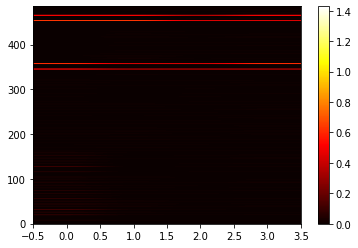

In [12]:
plt.imshow(q_table, origin='lower', aspect='auto', cmap='hot')
plt.colorbar()
plt.show()


R? 1 - path [0, 10, 20, 30, 40, 50, 60, 50, 51, 52, 62, 72, 71, 81, 91]


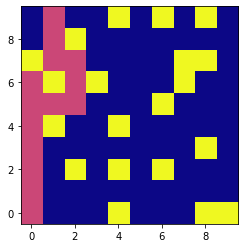

In [13]:
room = get_room(10)
visits = get_room(10)
pos = get_random_source(room)
apply_visit(visits, [pos])
apply_random_occupancy(room, pos, occ_prop)

loc = get_locality(room, visits, pos, margin)
s = get_state_id(room, loc, pos)
path = [pos]
path_visits = [visits.copy()]
for t in range(30):
  a = action_table(s)
  if a is None:
    print('none @ {}'.format(t))
    mvopt = move_options(room, pos)
    print(mvopt)
    choices = [i for i, mo in enumerate(mvopt) if mo]
    print(choices)
    a = random.choice(choices)
    print(a)
  pos, s = next_pos_state(room, visits, margin, pos, s, a) 
  path.append(pos)
  path_visits.append(visits.copy())
  if is_goal(room, s):
    break

print("R? {} - path {}".format(is_goal(room, s), path))
draw_room(room, visits)

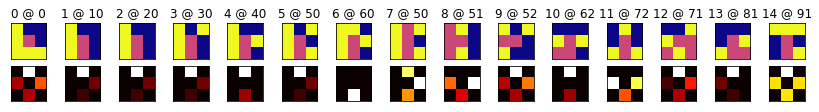

In [14]:
def map_actions(actions):
  grid = np.zeros((3, 3))
  grid[0][1] = actions[0]
  grid[1][2] = actions[1]
  grid[2][1] = actions[2]
  grid[1][0] = actions[3]
  return grid

plt_rows = 2
plt_cols = len(path)
fig, cht = plt.subplots(plt_rows, plt_cols)
fig.set_figwidth(0.96 * plt_cols)
fig.set_figheight(0.72 * plt_rows)
fig.set_facecolor('white')

for i, pos in enumerate(path):
  loc = get_locality(room, path_visits[i], pos, margin)
  cht[0][i].imshow(loc, vmin=0, vmax=2, origin='lower', cmap='plasma')
  cht[0][i].set_title('{} @ {}'.format(i, pos))
  cht[0][i].axes.xaxis.set_visible(False)
  cht[0][i].axes.yaxis.set_visible(False)

  s = get_state_id(room, loc, pos)
  cht[1][i].imshow(map_actions(q_table[s]), cmap='hot')
  cht[1][i].axes.xaxis.set_visible(False)
  cht[1][i].axes.yaxis.set_visible(False)

plt.show()